In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import math


In [3]:
playersdf = pd.read_csv("nfl-big-data-bowl-2023/players.csv")

scoutdf = pd.read_csv("nfl-big-data-bowl-2023/pffScoutingData.csv")

In [4]:
w1data = pd.read_csv("nfl-big-data-bowl-2023/week1.csv")
w1data.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


In [5]:
def collect_game_info(weekdf, playId, saved=False):
    #slice df to single play
    playdf = weekdf.loc[weekdf["playId"] == playId]
    #reorder playdf so that they are in the right frame order
    playdf = playdf.sort_values(by = "frameId")
    if saved:
        playdf.to_csv(f'Play{playId}Frames.csv')
        
    return playdf

In [6]:
def get_official_position(nflId):
    playerInfo = playersdf.loc[playersdf["nflId"] == nflId]
    playerInfo = playerInfo["officialPosition"].tolist()
    return playerInfo

In [7]:
def get_pff_role(nflId, playId, scoutdf):
    info = scoutdf.loc[(scoutdf["nflId"] == nflId) & (scoutdf["playId"] == playId)]
    info = info["pff_role"].tolist()
    return info

In [8]:
pffcolourdict = {}
pffcolourdict["Pass"] = "red"
pffcolourdict["Pass Route"] = "blue"
pffcolourdict["Pass Block"] = "green"
pffcolourdict["Pass Rush"] = "orange"
pffcolourdict["Coverage"] = "black"

In [9]:
play97df = collect_game_info(w1data, 90, True)

In [19]:
#try plotting specific frame of play
def plot_frame(playdf,playId, frameId,posTeam,resolution):
    #get just this frame
    framedf =  playdf.loc[playdf["frameId"] == frameId]
    fig, ax = plt.subplots()
    posTeamPoints = []
    defTeamPoints = []
    player_max_scores = []
    for index, row in framedf.iterrows():
        if row["team"] == posTeam:
            posTeamPoints.append([row["x"], row["y"]])
            player_max_scores.append(0)
        elif row["team"] == "football":
            ball_pos = [row["x"], row["y"]]
        else:
            defTeamPoints.append([row["x"], row["y"]])
    x_field_arr = np.arange(0,110+resolution,resolution)
    y_field_arr = np.arange(0,50+resolution,resolution)
    z_arr = np.zeros([len(y_field_arr)-1,len(x_field_arr)-1])
    xi = 0
    yi = 0
    mode = "c"
    for x in x_field_arr[:-1]:
        yi = 0
        for y in y_field_arr[:-1]:
            if mode == "c":#c for closest, voronoi plot
                min_dist = 1000000
                score = 0
                for player in defTeamPoints:#find the closest opposing player
                    weighted_dist = math.sqrt((x-player[0])**2 + (y-player[1])**2)
                    if weighted_dist < min_dist:
                        min_dist = weighted_dist
                        
                for player in posTeamPoints:
                    weighted_dist = math.sqrt((x-player[0])**2 + (y-player[1])**2)#/player[3]
                    if weighted_dist < min_dist:
                        min_dist = weighted_dist
                        #ball_speed = 27m/s, player_speed = 8.5 m/s
                        ball_dist = math.sqrt((x-35)**2 + (y-23)**2)
                        #score = yard gain * sigmoid of time ratio between ball and player
                        score = (x-35)*math.tanh(ball_dist*8.5/(weighted_dist*27))
                        best_player = player
                try:
                    player_ind = posTeamPoints.index(best_player)
                    if score > player_max_scores[player_ind]:
                        player_max_scores[player_ind] = score
                except:
                    UnboundLocalError

            elif mode == "a":
                score = x-35
                for player in posTeamPoints:
                    score += math.sqrt((x-player[0])**2 + (y-player[1])**2)
                for player in defTeamPoints:
                    score -= math.sqrt((x-player[0])**2 + (y-player[1])**2)

            z_arr[yi,xi] = score
            yi += 1
            #print(yi,xi)
        xi += 1

    
    mesh = ax.pcolormesh(x_field_arr,y_field_arr,z_arr)
    for player in posTeamPoints:
        ax.scatter(player[0],player[1],color = 'b')
    for player in defTeamPoints:
        ax.scatter(player[0],player[1],color = 'r') 
    ax.scatter(ball_pos[0],ball_pos[1],color = 'black')
    fig.colorbar(mesh)
    fig.show()
    for i in range(len(posTeamPoints)):
        print(f'Player at position {posTeamPoints[i][0]},{posTeamPoints[i][1]} had a score of {player_max_scores[i]}')

def plot_animation(playId, maxFrameId,resolution,type):
    playdf = collect_game_info(w1data, playId, False)
    gameId = playdf["gameId"].unique()[0]
    
    #get attacking team (one with QB)
    searchdf = pd.read_csv("nfl-big-data-bowl-2023/plays.csv")
    searchdf = searchdf.loc[searchdf["playId"] == playId]
    searchdf = searchdf.loc[searchdf["gameId"] == gameId]
    possessionTeam = searchdf["possessionTeam"].unique()[0]
    if type == "s":#s for single frame- last frame
        plot_frame(playdf,"",maxFrameId,possessionTeam, resolution)
    else:
        for frame in range(1,maxFrameId):
            plot_frame(playdf,"",frame,possessionTeam, resolution)
    
        



C:\Users\foata\AppData\Local\Temp\ipykernel_18736\4099906083.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Player at position 36.14,25.59 had a score of 1.6620218470847532
Player at position 54.12,42.07 had a score of 22.246300469083902
Player at position 39.01,27.57 had a score of 4.715062770095837
Player at position 37.27,22.18 had a score of 3.0690293059768026
Player at position 35.13,23.21 had a score of 0.3617129123497183
Player at position 46.2,29.93 had a score of 13.193975992517064
Player at position 34.13,24.35 had a score of 0
Player at position 52.68,24.14 had a score of 20.10385229385499
Player at position 37.1,16.75 had a score of 5.5082604247858455
Player at position 33.1,21.56 had a score of 0
Player at position 46.13,42.9 had a score of 12.739907477884554


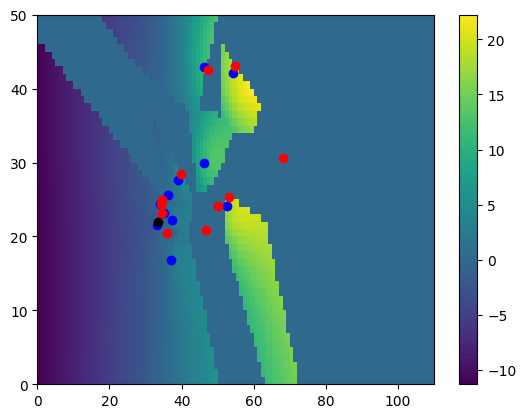

In [20]:
plot_animation(97,37,1,"s")

C:\Users\foata\AppData\Local\Temp\ipykernel_18736\3336211071.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


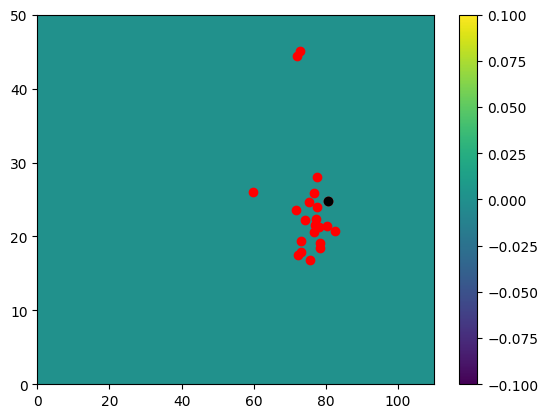

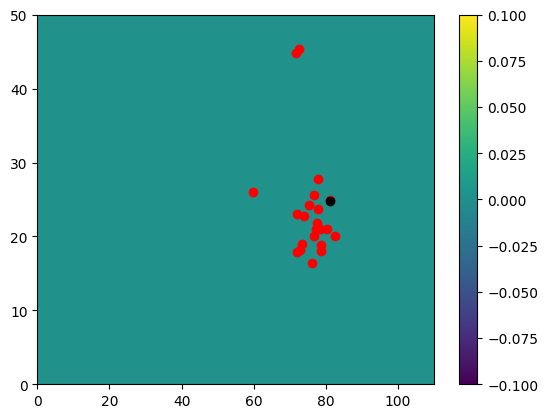

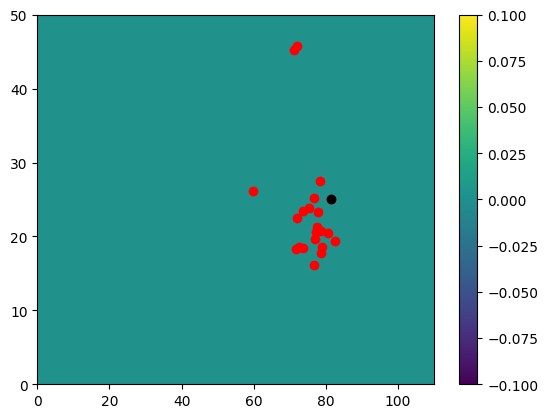

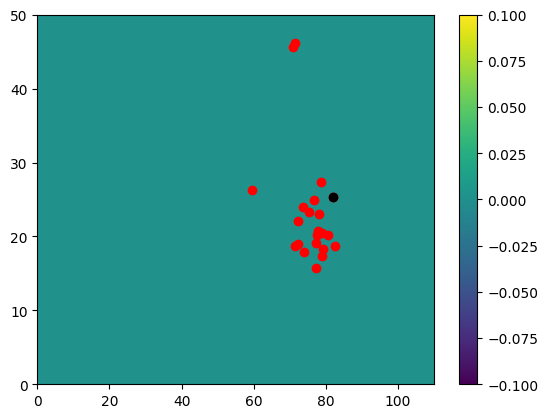

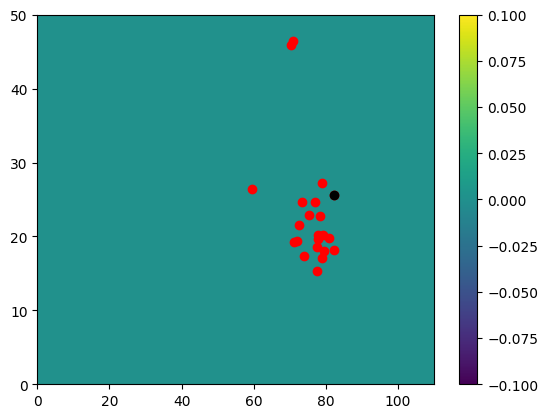

In [12]:
for i in range(20,25):
    plot_frame(play97df,'',i,'',2)